In [1]:
print('hello world')

hello world


In [2]:
import pandas as pd
import maboss
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
conda env list

# conda environments:
#
base                     /home/rtrimbour/miniconda3
colosys                  /home/rtrimbour/miniconda3/envs/colosys
maboss                   /home/rtrimbour/miniconda3/envs/maboss
maboss_ensemble       *  /home/rtrimbour/miniconda3/envs/maboss_ensemble
scconnect                /home/rtrimbour/miniconda3/envs/scconnect
stream                   /home/rtrimbour/miniconda3/envs/stream


Note: you may need to restart the kernel to use updated packages.


## **Load the general model**

In [4]:
fname = 'new_f_p38gsk3'
## Set up the required files
bnd_file = fname+".bnd"
cfg_WT = fname+".bnd.cfg"

Load the model with either all 0s or random initial conditions and modify some configuration parameters. Note that if you used the export of GINsim export, all the initial values will be set to 0

In [5]:
## Load the Wild-Type model
WT = maboss.load(bnd_file, cfg_WT)

## modify the max_time if necessary
## select the variables considered to be internal (not appearing in the resulting csv file) 
## run the model for random initial conditions (defined in the cfg file) or from all 0s initial conditions 

WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':100})

## By default, all variables are external (in the cfg file: Node.is_internal = FALSE). 
## If the model is big, the computations may take a very long time.
## We advise to set as external, only the variables that are relevant for the analysis

## if you wish to put some values as internal (the ones that will not be used for the analysis), write (uncomment):
#for name in "ERK_1_2 MK2 p38 Wee1 BRAF CDK1 p21 TP53 Proliferation Senescence Apoptosis".split(' '):
for name in "TAK1 PI3K MTORC2 CDC25A CDK4_6 S6 EIF4EBP1 JNK AKT p38 p21 HSP27 cPARP CC3".split(' '):
     WT_allinputs.network[name].is_internal = True

In [6]:
#help(WT_allinputs.network.set_istate)

/home/rtrimbour/miniconda3/envs/maboss_ensemble/lib/python3.7/site-packages/maboss/figures.py:87: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  startangle=90, colors=color_list, **opts)


Text(0.5, 1.0, 'WT pie chart')

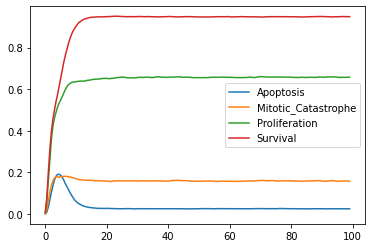

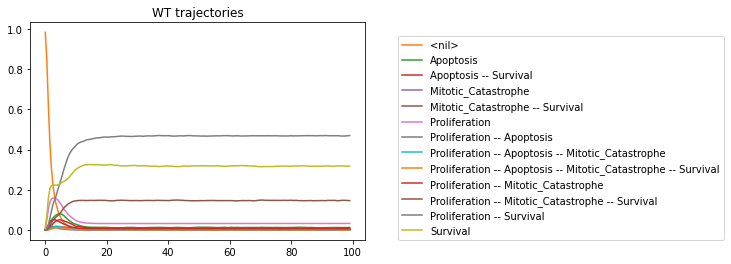

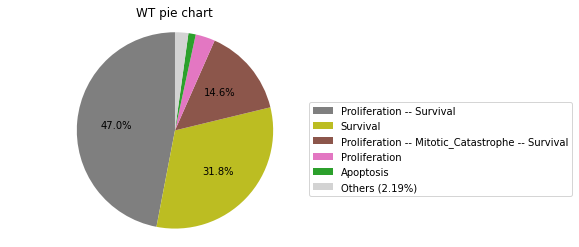

In [6]:
## Select outputs for visualisation of the results
WT_allinputs.network.set_output(('Proliferation','Apoptosis','Mitotic_Catastrophe','Survival'))
#WT_allinputs.network.set_output(('CHEK1','CHEK2','AKT','MEK','NFkB','TP53','ERK_1_2','CASP3'))

WT_allinputs.network.set_istate('FGFR',[0.5,0.5])
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0.5,0.5])
WT_allinputs.network.set_istate('DSB_SSB',[0.5,0.5])
WT_allinputs.network.set_istate('TNF',[0.5,0.5])
WT_allinputs.network.set_istate('Wnt',[0.5,0.5])
WT_allinputs.network.set_istate('IL1R1',[0.5,0.5])
WT_allinputs.network.set_istate('IL6',[0.5,0.5])
WT_allinputs.network.set_istate('IFNA',[0.5,0.5])




## Run a MaBoSS simulation
run_WT_allinputs = WT_allinputs.run()

## Plot the results of the WT simulation
run_WT_allinputs.get_nodes_probtraj().plot(legend=True)
run_WT_allinputs.plot_trajectory(legend=True)
plt.title('WT trajectories')
# Plot pie chart
run_WT_allinputs.plot_piechart()
plt.title('WT pie chart')

In [8]:
st = run_WT_allinputs.last_states_probtraj
death_rate = sum(st[s] for s in st if 'Apopotosis' in s or 'Mitotic' in s)

survi_rate = 1-death_rate
survi_rate

99.0000    0.638879
dtype: float64

In [9]:
for s in st:
    if 'Mito' in s or 'Apop' in s:
        print(s)

Apoptosis -- Mitotic_Catastrophe -- Survival -- TP53
Apoptosis -- Mitotic_Catastrophe -- TP53
Apoptosis -- Survival -- TP53
Apoptosis -- TP53
BCL2 -- Mitotic_Catastrophe -- NFkB -- Survival -- TP53
BCL2 -- Mitotic_Catastrophe -- Survival -- TP53
Proliferation -- Apoptosis -- Mitotic_Catastrophe -- Survival -- TP53
Proliferation -- Apoptosis -- Mitotic_Catastrophe -- TP53
Proliferation -- Apoptosis -- Survival -- TP53
Proliferation -- Apoptosis -- TP53
Proliferation -- BCL2 -- Mitotic_Catastrophe -- NFkB -- Survival -- TP53
Proliferation -- BCL2 -- Mitotic_Catastrophe -- Survival -- TP53
Proliferation -- Mitotic_Catastrophe
Proliferation -- Mitotic_Catastrophe -- NFkB -- Survival


In [10]:
#help(sb.scatterplot)

## Objects defined as cell lines and ensemble of cells to group all the cell lines and conditions of experiment

In [11]:
class Cellline:
    def __init__(self, name, mutations, transition_rates_up, initial_states, dict_gene_nodes, dict_strict_gene_nodes):
        self.name = name
        self.mutations = mutations
        self.transition_rates_up = transition_rates_up
        self.initial_states = initial_states
        self.dict_gene_nodes = dict_gene_nodes
        self.dict_strict_gene_nodes = dict_strict_gene_nodes
    def __repr__(self):
        try :
            self.model
            try:
                self.results
                return self.name+', simu'
            except:
                return self.name+', compu'
        except:
            return self.name 
    
    def personalize_model(self, model):
        personalized_model = model.copy()
        nodes = model.network.names
        
        for node in nodes:
            to_inverse=False
            if node in self.dict_gene_nodes:
                for gene in self.dict_gene_nodes[node]:
                    if gene[0]=='!':
                        to_inverse = True
                        gene = gene[1:]
                    if gene in self.mutations.keys():
                        val_mut = self.mutations[gene]
                        if to_inverse:
                            if val_mut=='ON':
                                val_mut ='OFF'
                            else:
                                val_mut = 'ON'
                        personalized_model.mutate(node, val_mut)
            if node in self.dict_strict_gene_nodes:
                for gene in self.dict_strict_gene_nodes[node]:
                    if gene in self.transition_rates_up.keys():
                        print('changing transition rates of {}'.format(gene))
                        personalized_model.param['$u_'+node] = self.transition_rates_up[gene]
                        personalized_model.param['$d_'+node] = 1/self.transition_rates_up[gene]
            if len(self.initial_states)!=0:
                for node in self.initial_states:
                    personalized_model.network.set_istate(node, self.initial_states[node])
        self.model = personalized_model
        return personalized_model
    
    def run_simulation(self):
        self.results = self.model.run()
        print('done')

In [12]:
class CellEnsemble:
    def __init__(self, celllines, general_model):
        self.model = general_model
        self.data = celllines
        self.simu = {'base':{cellname:Cellline(**celllines[cellname])
                             for cellname in celllines}}
        self.update()
    def __repr__(self):
        return 'conditions : '+str(list(self.simu.keys()))+'\ncell lines : '+str(list(self.simu['base'].keys()))
    def resume(self):
        """Plot the names of the personalized models stored, under a pandas.DataFrame format."""
        return pd.DataFrame(self.simu)
    
    def add_condition(self, conditions, condition_name):
        """Add a condition (new version of each cell line personalized model with mutations) to the CellEnsembl object
        conditions : mutations in the MaBoSS format : (Node_name, effect). The effect can be 'ON' or 'OFF'. For mutliple mutation, a list or tuple can be given.
        condition_name : name of the condition to call them and to define title of the output graphs.
        """
        self.simu[condition_name] = {cellname:Cellline(**celllines[cellname])
                                     for cellname in celllines}
        self.update()
        if type(conditions[0]) is not str:
            print('{} mutations for the condition {}'.format(len(conditions), condition_name))
            for condition in conditions:
                for k in self.simu[condition_name]:
                    self.simu[condition_name][k].model.mutate(*condition)
        else:
            for k in self.simu[condition_name]:
                self.simu[condition_name][k].model.mutate(*conditions)
    
    def update(self, new_model=None):
        """By default, the method recreates personalized versions of the model which is stored as an attribute : self.model.
        new model : You can also give the new version of the general model directly as an argument in this method with this argument.
        It allow to keep the format of the CellEnsembl object (conditions and celllines) but to change the general model used.
        """
        if new_model is not None:
            self.model = new_model
            
        for k1 in self.simu:
            for k2 in self.simu[k1]:
                self.simu[k1][k2].personalize_model(self.model)
    
    def run_simulation(self, celllines='all', conditions='all', redo=True, mute=False):
        
        if celllines == 'all':
            celllines = list(self.simu['base'].keys())
        elif type(celllines) not in [list, tuple]:
            celllines = [celllines]
        if conditions == 'all':
            conditions = list(self.simu.keys())
        elif type(conditions) not in [list, tuple]:
            conditions = [conditions]
            
        for condition in conditions:
            for cellline in celllines:
                if redo==False:
                    try:
                        self.simu[condition][cellline].results
                        if mute==False:
                            print('the simulation {}|{} will not be re-computed'.format(cellline, condition))
                        continue
                    except:
                        pass
                if mute==False:
                    print('Simulating', cellline, 'in the condition', condition)
                self.simu[condition][cellline].run_simulation()
                
       
    def plot_piechart(self, celllines='all', conditions='all'):
        if celllines == 'all':
            celllines = list(self.simu['base'].keys())
        elif type(celllines) not in [list, tuple]:
            celllines = [celllines]
        if conditions == 'all':
            conditions = list(self.simu.keys())
        elif type(conditions) not in [list, tuple]:
            conditions = [conditions]
            
        
        if len(conditions)>1:
            for cellline in celllines:
                fig, axs = plt.subplots(1, len(conditions), figsize=(8*len(conditions),5), constrained_layout=True)
                for condition in conditions:
                    try: 
                        self.simu[condition][cellline].results.plot_piechart(axes = axs[conditions.index(condition)])
                        axs[conditions.index(condition)].set_title(cellline + ' | ' + condition)
                    except:
                        print('the simulation {}|{} seems not having been computed'.format(cellline, condition))
        else:
            for condition in conditions:
                for cellline in celllines:
                    try: 
                        self.simu[condition][cellline].results.plot_piechart()
                        plt.title(cellline + ' | ' + condition)
                    except:
                        print('the simulation {}|{} seems not having been computed'.format(cellline, condition))
    def plot_trajectory(self, celllines='all', conditions='all'):
        if celllines == 'all':
            celllines = list(self.simu['base'].keys())
        elif type(celllines) not in [list, tuple]:
            celllines = [celllines]
        if conditions == 'all':
            conditions = list(self.simu.keys())
        elif type(conditions) not in [list, tuple]:
            conditions = [conditions]
            
        
        if len(conditions)>1:
            for cellline in celllines:
                fig, axs = plt.subplots(1, len(conditions), figsize=(8*len(conditions),5), constrained_layout=True)
                for condition in conditions:
                    try: 
                        self.simu[condition][cellline].results.plot_trajectory(axes = axs[conditions.index(condition)])
                        axs[conditions.index(condition)].set_title(cellline + ' | ' + condition)
                    except:
                        print('the simulation {}|{} seems not having been computed'.format(cellline, condition))
        else:
            for condition in conditions:
                for cellline in celllines:
                    try: 
                        self.simu[condition][cellline].results.plot_trajectory()
                        plt.title(cellline + ' | ' + condition)
                    except:
                        print('the simulation {}|{} seems not having been computed'.format(cellline, condition))

                        
                        
    def compare_survival(self, celllines='all', conditions='all'):
        
        outputs_df = pd.DataFrame(index=[], columns=['proliferation_rates', 'survival_rates'])
        
        if celllines == 'all':
            celllines = list(self.simu['base'].keys())
        elif type(celllines) not in [list, tuple]:
            celllines = [celllines]
        if conditions == 'all':
            conditions = list(self.simu.keys())
        elif type(conditions) not in [list, tuple]:
            conditions = [conditions]
            
        for condition in conditions:
            for cellline in celllines:
                outputs_dict = {'survival_rates' : {}, 'proliferation_rates' : {}}

                st = self.simu[condition][cellline].results.last_states_probtraj
                death_rate = float(sum(st[s] for s in st if 'Apoptosis' in s or 'Mitotic' in s))
                proliferation = float(sum(st[s] for s in st if 'Apoptosis' not in s and 'Mitotic' not in s and 'Prolif' in s))

                outputs_dict['survival_rates'][condition+'_'+cellline] =  1-death_rate
                outputs_dict['proliferation_rates'][condition+'_'+cellline] = proliferation
                outputs_df = pd.concat([pd.DataFrame(outputs_dict), outputs_df])
        return outputs_df
                

## Personalisation of the celllines

Import the mutation data

In [33]:
fname_mutations_effect = "../mutations/profile_analysis/heterozygous_clines_mutations_impact.csv"
df = pd.read_csv(fname_mutations_effect, index_col=0)
df.columns = [col.upper() for col in df.columns]
df = df.replace(0.0, 'OFF')
df = df.replace(1.0, 'ON')
dict_mut = df.to_dict()
for key in dict_mut.keys():
    dict_mut[key] = {k: v for k, v in dict_mut[key].items() if v in ['ON','OFF']}

#df of mutations
df.head()

,CAR1,HT29,LS411N,SW1417,SW1463,SW403,SW480,SW620,SW837,HCT116
ADAM2,OFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADGRG4,OFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AKAP13,OFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMPD1,OFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANKRD36,OFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
nAme = 'WIP'
[gene for gene in df.index if nAme in gene]

ERROR! Session/line number was not unique in database. History logging moved to new session 190


['WIPF1']

In [35]:
d = {
     'HCT116': dict_mut['HCT116']}
             
pd.DataFrame(d).head()

,HCT116
AACS,OFF
AARS2,OFF
AASDHPPT,OFF
ABCA13,OFF
ABCA8,OFF


In [36]:
#df.loc['AXIN2']

Import the transition rates file generated from the script : "test_mutations_effect"

In [37]:
df_u = pd.read_csv('test_tr_up.csv', index_col=0)
df_u.head()

,MAP3K7,SMAD4,IL1R1,FGFR1,EGF,TGFBR1,KRAS,BRAF,MAPK14,CHEK1,MAPKAPK2,CDC25B,CDC25A,CDK1,CDK2,EGFR,MAPK8,ATR,ATM,CHEK2,MTOR,EIF4EBP1,TP53,CDKN1A,CDKN1A.1,CDKN1A.2,CDKN1A.3,CDKN1A.4,CDKN1A.5,CDKN1A.6,CDKN1A.7,CDK4,RPS6,AKT1,PIK3CA,PKMYT1,RELA,PLK1,CASP3,MYC,CDC6,CTNNB1,LEF1,NLK,JUN,TNF,TRAF6,NFKBIA,CHUK,IL6R,JAK1,STAT3,SOS1,ATF2,BCL2,BCL2L11,IFNLR1,FADD,CASP8,TRAF2,FOXO1,MYD88,IRAK4,CDKN1A.8,CDKN1A.9,CDKN1A.10,CDKN1A.11,CDKN1A.12,CDKN1A.13,CDKN1A.14,CDKN1A.15,PDK1,MAP2K1,MAPK3,GSK3B,PTPN1
CaCo2,300.000000,300.0,300.000000,296.375466,0.061046,14.881147,73.758470,0.432766,133.119993,75.883954,1.107929,0.009877,69.061189,229.746670,43.549927,0.427236,0.006823,0.060944,1.926710,6.139001,0.308115,0.057560,0.003392,0.014681,0.014681,0.014681,0.014681,0.014681,0.014681,0.014681,0.014681,4.834666,0.007071,0.031155,0.059969,0.017216,0.027628,10.010285,0.717851,0.084649,33.194020,0.005063,33.543242,297.471331,0.018128,145.092469,0.237738,0.107630,0.929818,0.154980,0.004470,0.006266,129.398650,14.588853,285.875802,0.996434,1.840336,0.033264,23.180067,56.008696,0.456596,0.059553,0.016294,0.014681,0.014681,0.014681,0.014681,0.014681,0.014681,0.014681,0.014681,0.905543,1.177219,0.007651,0.232916,222.378169
CL-11,0.003333,300.0,300.000000,0.028015,0.077080,0.006010,0.013333,265.817213,0.003509,0.131135,171.028457,19.139207,83.466583,1.257583,10.092495,165.124091,6.117421,3.712588,0.134708,0.003388,18.726328,0.053158,0.011652,9.498743,9.498743,9.498743,9.498743,9.498743,9.498743,9.498743,9.498743,177.104443,0.098643,10.028161,119.586679,147.269975,126.666275,19.371400,1.216947,0.018442,0.450842,46.112207,185.081435,249.129334,0.160000,4.885802,72.305240,1.354105,14.746127,261.457563,2.800630,0.053948,16.383943,0.047864,1.750468,1.003590,0.753253,23.333424,2.989548,1.000000,55.356284,76.579709,0.626298,9.498743,9.498743,9.498743,9.498743,9.498743,9.498743,9.498743,9.498743,0.009444,0.050209,0.016633,0.038628,32.529571
CL-34,0.003333,300.0,0.003333,0.079405,299.995104,0.412735,0.032198,0.005990,13.913604,0.010957,1.007752,15.471066,0.506485,0.558704,0.110304,0.258524,21.899602,1.268658,0.024551,1.857604,0.699150,85.463440,25.423691,71.689206,71.689206,71.689206,71.689206,71.689206,71.689206,71.689206,71.689206,108.948602,68.733266,1.057924,0.142265,0.394524,0.020889,21.041456,43.099542,94.628164,0.617944,2.549961,0.203284,0.213717,0.056183,0.059930,0.036369,0.052655,8.230883,0.085532,21.645286,1.560297,0.110728,0.167861,232.274124,0.110911,0.011345,0.085217,0.295774,0.077980,1.041324,0.960380,20.375431,71.689206,71.689206,71.689206,71.689206,71.689206,71.689206,71.689206,71.689206,8.067523,85.611808,1.892375,0.077661,0.006637
CL-40,0.003333,300.0,300.000000,0.088799,299.981234,0.038902,16.650918,0.005402,1.660215,0.005196,86.620921,0.265923,4.553023,0.007350,0.834593,5.522775,1.088219,0.009557,0.006031,0.011431,0.116256,0.018813,13.469441,240.544252,240.544252,240.544252,240.544252,240.544252,240.544252,240.544252,240.544252,0.405010,0.097856,0.541024,0.120432,0.417878,167.047249,2.773218,0.655223,1.076396,1.082578,5.958394,8.317155,1.221067,1.554700,32.306678,4.438334,2.122741,2.437900,0.068244,0.316165,47.692218,2.267589,0.015340,0.679887,0.059025,12.139264,0.011108,1.526886,0.008782,33.316960,203.884008,6.701267,240.544252,240.544252,240.544252,240.544252,240.544252,240.544252,240.544252,240.544252,11.634251,0.133854,174.862188,15.743043,0.501203
Co115,300.000000,300.0,300.000000,0.062643,0.028461,20.367730,0.009904,0.007813,0.803918,6.084120,8.828249,0.026225,0.555238,27.416053,32.878420,215.836467,191.835938,0.788226,1.232648,104.223302,174.501116,0.820804,108.493304,138.113339,138.113339,138.113339,138.113339,138.113339,138.113339,138.113339,138.113339,0.111584,32.539526,0.389815,0.009388,22.898205,1.722247,0.134343,27.607569,34.102718,100.231497,2.213173,0.736961,0.004891,0.029371,0.066650,0.049570,178.592198,60.936204,0.034340,0.003643,6.937318,0.915825,20.427951,1.470825,45.972018,0.184239,9.073670,3.902649,16.426375,0.960313,1.410157,0.

In [38]:
dic_tr_up = df_u.transpose().to_dict()
dic_tr_up.keys()

cellnames = list(dict_mut.keys())


dic_tr_up = {k:v for k,v in dic_tr_up.items() if k in cellnames}
for k2 in cellnames:
    if k2 not in dic_tr_up.keys():
        dic_tr_up[k2]={}
        
#dic_tr_up

**Import the file containing correspondance between nodes of the model and name of the genes mutated**

In [39]:
dict_gene_nodes = {
    "bCAT":{'!APC', 'CTNNB1', '!AXIN2'},
    "TGFb":{'TGFBR1'}, #TGFBR2
    'RAS_b2':{'KRAS'},
    'RAS_b1':{'KRAS'},
    'BRAF_b2':{"BRAF"},
    'BRAF_b1':{"BRAF"},
    'TP53':{'TP53'},
    'PI3K' : {'PIK3CA', 'PI3K'},
    'SMAD4' : {'SMAD4'},
    'STAT3' : {'STAT3'},
    'CASP3' : {'CASP3'},
    'CASP8' : {'CASP8'},
    'p38'  : {'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14'},
    'IL1R1'  : {"IL1R1", "IL1R2"},
    'IL6'  : {'IL7R', "IL1R1", "IL1R2"},
    'IFNAR'  : {"IFNLR1"},
    'CHUK' : {'CHUK'}
}

dict_strict_gene_nodes = {
    "bCAT" : {'CTNNB1'},
    'TGFb' : {'TGFBR1'},
    'BRAF_b1' : {'BRAF'},
    'RAS_b1' : {'KRAS'},
    'TP53' : {'TP53'},
    'PI3K' : {'PIK3CA'},
    'SMAD4' : {'SMAD4'},
    'STAT3' : {'STAT3'},
    'CASP3' : {'CASP3'},
    'CASP8' : {'CASP8'},
    'p38'  : {'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14'},
    'IL1R1'  : {"IL1R1", "IL1R2"},
    'IL6'  : {'IL7R', "IL1R1", "IL1R2"},
    'IFNAR'  : {"IFNLR1"},
    'CHUK' : {'CHUK'}
} 

dict_strict_gene_nodes['FGFR'] = {'FGFR1'}
dict_strict_gene_nodes['PTPN1'] = {'PTPN1'}
dict_strict_gene_nodes['TGFb'] = {'TGFBR1'}
dict_strict_gene_nodes['bCAT'] = {'CTNNB1'}
dict_strict_gene_nodes['TGFb'] = {'TGFBR1'} 
dict_strict_gene_nodes['RAS_b1'] = {'KRAS'}
dict_strict_gene_nodes['BRAF_b1'] = {"BRAF"}
dict_strict_gene_nodes['TP53'] = {'TP53'}
dict_strict_gene_nodes['PI3K'] = {'PIK3CA'}
dict_strict_gene_nodes['SMAD4'] = {'SMAD4'}
dict_strict_gene_nodes['STAT3'] = {'STAT3'}
dict_strict_gene_nodes['CASP3'] = {'CASP3'}
dict_strict_gene_nodes['CASP8'] = {'CASP8'}
dict_strict_gene_nodes['p38'] =  {'MAPK14'}
dict_strict_gene_nodes['IL1R1'] =  {"IL1R1"}
dict_strict_gene_nodes['IL6'] = {'IL6R'}
dict_strict_gene_nodes['IFNAR'] = {"IFNLR1"}
dict_strict_gene_nodes['CHUK'] = {'CHUK'}
dict_strict_gene_nodes['CDK4_6'] = {'CDK4'}
dict_strict_gene_nodes['AKT'] = {'AKT1'}
dict_strict_gene_nodes['MEK_1_2'] = {'MAP2K1'}
dict_strict_gene_nodes['ERK_1_2'] = {'MAPK3'}
dict_strict_gene_nodes['MK2'] = {'MAPKAPK2'}
dict_strict_gene_nodes['CDC25B_C'] = {'CDC25B'}
dict_strict_gene_nodes['GSK3B'] = {'GSK3B'}
dict_strict_gene_nodes['JNK'] = {'MAPK8'}
dict_strict_gene_nodes['JAK'] = {'JAK1'}
dict_strict_gene_nodes['TAK1'] = {'MAP3K7'}
dict_strict_gene_nodes['IkB'] = {'NFKBIA'}
dict_strict_gene_nodes['NFkB'] = {'RELA'}
dict_strict_gene_nodes['MTORC1'] = {'MTOR'}
dict_strict_gene_nodes['p21'] = {'CDKN1A'}
dict_strict_gene_nodes['S6'] = {'RPS6'}
dict_strict_gene_nodes['MYC_b1'] = {'MYC'}


#### **initial states**

In [40]:
initial_proba = pd.read_csv('initial_proba.csv', index_col=0)
initial_proba.head()

,MAP3K7,SMAD4,IL1R1,FGFR1,EGF,TGFBR1,KRAS,BRAF,MAPK14,CHEK1,MAPKAPK2,CDC25B,CDC25A,CDK1,CDK2,EGFR,MAPK8,ATR,ATM,CHEK2,MTOR,EIF4EBP1,TP53,CDKN1A,CDKN1A.1,CDKN1A.2,CDKN1A.3,CDKN1A.4,CDKN1A.5,CDKN1A.6,CDKN1A.7,CDK4,RPS6,AKT1,PIK3CA,PKMYT1,RELA,PLK1,CASP3,MYC,CDC6,CTNNB1,LEF1,NLK,JUN,TNF,TRAF6,NFKBIA,CHUK,IL6R,JAK1,STAT3,SOS1,ATF2,BCL2,BCL2L11,IFNLR1,FADD,CASP8,TRAF2,FOXO1,MYD88,IRAK4,CDKN1A.8,CDKN1A.9,CDKN1A.10,CDKN1A.11,CDKN1A.12,CDKN1A.13,CDKN1A.14,CDKN1A.15,PDK1,MAP2K1,MAPK3,GSK3B,PTPN1
CaCo2,1,1,1,0.998934,0.254888,0.736693,0.877013,0.426579,0.928773,0.879503,0.508985,0.095224,0.871244,0.976612,0.830825,0.425451,0.062794,0.254742,0.557489,0.659075,0.396798,0.249734,0.001524,0.129963,0.129963,0.129963,0.129963,0.129963,0.129963,0.129963,0.129963,0.638137,0.065927,0.195923,0.253328,0.143928,0.185391,0.701937,0.470941,0.283544,0.807022,0.036649,0.807939,0.999258,0.148451,0.936322,0.374067,0.304598,0.493621,0.336560,0.025723,0.055328,0.926287,0.734954,0.995773,0.499687,0.553469,0.201666,0.775545,0.852881,0.431277,0.252718,0.139101,0.129963,0.129963,0.129963,0.129963,0.129963,0.129963,0.129963,0.129963,0.491302,0.514302,0.072830,0.372271,0.973754
CL-11,0,1,1,0.186611,0.275332,0.051679,0.121519,0.989395,0.004514,0.321914,0.950739,0.758753,0.887852,0.520091,0.702654,0.947659,0.658767,0.614988,0.324270,0.001423,0.756841,0.242760,0.109710,0.697339,0.697339,0.697339,0.697339,0.697339,0.697339,0.697339,0.697339,0.953799,0.296955,0.702094,0.919374,0.937628,0.924416,0.759810,0.517212,0.149959,0.430166,0.835837,0.957661,0.983712,0.339354,0.639060,0.875268,0.526574,0.735894,0.987946,0.590277,0.244053,0.745127,0.233564,0.549080,0.500314,0.475161,0.776123,0.596000,0.500000,0.851853,0.880303,0.458981,0.697339,0.697339,0.697339,0.697339,0.697339,0.697339,0.697339,0.697339,0.091293,0.237757,0.140910,0.214771,0.805249
CL-34,0,1,0,0.277937,0.999999,0.422424,0.198809,0.051382,0.730800,0.104319,0.500677,0.740101,0.440368,0.448969,0.306750,0.381415,0.770563,0.520860,0.175038,0.554287,0.468627,0.889924,0.783644,0.874518,0.874518,0.874518,0.874518,0.874518,0.874518,0.874518,0.874518,0.911207,0.870827,0.504936,0.329055,0.418469,0.160879,0.767059,0.829914,0.898854,0.457804,0.582058,0.360343,0.364730,0.247612,0.253271,0.209488,0.241927,0.684780,0.284453,0.769539,0.538998,0.307086,0.343558,0.977571,0.307231,0.107366,0.284130,0.393215,0.276350,0.503550,0.496456,0.764240,0.874518,0.874518,0.874518,0.874518,0.874518,0.874518,0.874518,0.874518,0.683023,0.890077,0.555913,0.275991,0.060377
CL-40,0,1,1,0.287739,0.999995,0.215390,0.746544,0.042317,0.544440,0.038921,0.891104,0.383889,0.632876,0.069317,0.484150,0.649802,0.507411,0.092334,0.051971,0.108029,0.311357,0.151706,0.727956,0.980638,0.980638,0.980638,0.980638,0.980638,0.980638,0.980638,0.980638,0.420768,0.296253,0.446150,0.314450,0.423510,0.948674,0.589415,0.462939,0.506453,0.506956,0.656458,0.685694,0.517508,0.538683,0.804646,0.630640,0.565983,0.578118,0.264659,0.399059,0.838790,0.571770,0.133813,0.466178,0.251937,0.718841,0.105515,0.537101,0.084921,0.807346,0.966143,0.666757,0.980638,0.980638,0.980638,0.980638,0.980638,0.980638,0.980638,0.980638,0.715116,0.323713,0.952682,0.741629,0.439449
Co115,1,1,1,0.257152,0.187996,0.764206,0.095462,0.074672,0.480867,0.658288,0.690922,0.180822,0.448424,0.790257,0.806184,0.971137,0.960803,0.479139,0.518336,0.907321,0.952501,0.482689,0.910840,0.932001,0.932001,0.932001,0.932001,0.932001,0.932001,0.932001,0.932001,0.307761,0.805276,0.417416,0.090765,0.774472,0.547655,0.324032,0.790867,0.809389,0.903897,0.569640,0.473244,0.033616,0.190754,0.262588,0.236634,0.954532,0.860272,0.204457,0.007787,0.669792,0.492292,0.764465,0.533822,0.835570,0.351719,0.693326,0.619364,0.745354,0.496450,0.530129,0.033640,0.932001,0.932001,0.932001,0.932001,0.932001,0.932001,0.932001,0.932001,0.856739,0.942273,0.249401,0.088324,0.300615


In [41]:
initial_states = {cellname:{} for cellname in cellnames}

for cellname in cellnames:
    if cellname in initial_proba.index:
        for gene in initial_proba.columns:
            for node in dict_strict_gene_nodes:
                if gene in dict_strict_gene_nodes[node]:
                    initial_states[cellname][node] = {0:1-initial_proba.loc[cellname, gene], 1:initial_proba.loc[cellname, gene]}

    else:
        initial_states[cellname] = {}

In [42]:
cellname, initial_states[cellname]

('HCT116',
 {'TAK1': {0: 0, 1: 1},
  'SMAD4': {0: 0, 1: 1},
  'IL1R1': {0: 0, 1: 1},
  'FGFR': {0: 0.0011115699999999507, 1: 0.99888843},
  'TGFb': {0: 0.39913297000000003, 1: 0.60086703},
  'RAS_b1': {0: 0.78674723, 1: 0.21325277},
  'BRAF_b1': {0: 0.24544509999999997, 1: 0.7545549},
  'p38': {0: 0.82296965, 1: 0.17703035},
  'MK2': {0: 0.83714607, 1: 0.16285393},
  'CDC25B_C': {0: 0.08975060000000001, 1: 0.9102494},
  'JNK': {0: 0.36097539999999995, 1: 0.6390246},
  'MTORC1': {0: 0.69324622, 1: 0.30675378},
  'TP53': {0: 0.5704396700000001, 1: 0.42956033},
  'p21': {0: 0.03690106000000004, 1: 0.96309894},
  'CDK4_6': {0: 0.79061286, 1: 0.20938714},
  'S6': {0: 0.17751070000000002, 1: 0.8224893},
  'AKT': {0: 0.57074574, 1: 0.42925426},
  'PI3K': {0: 0.35596657, 1: 0.64403343},
  'NFkB': {0: 0.79272722, 1: 0.20727278},
  'CASP3': {0: 0.986857101, 1: 0.013142899},
  'MYC_b1': {0: 0.41534380000000004, 1: 0.5846562},
  'bCAT': {0: 0.65955684, 1: 0.34044316},
  'IkB': {0: 0.32023232999999

Create a dictionary containing all the necessary informations to define the celllines

In [43]:
cellnames = list(dict_mut.keys())
celllines = {}
for cellname in cellnames:
    celllines[cellname] = {"name":cellname,
                           "mutations" : dict_mut[cellname],
                           "transition_rates_up":dic_tr_up[cellname.upper()],
                           "dict_gene_nodes":dict_gene_nodes,
                           'initial_states':initial_states[cellname],
                           'dict_strict_gene_nodes':dict_strict_gene_nodes}

In [44]:
pd.DataFrame(celllines)

,CAR1,HT29,LS411N,SW1417,SW1463,SW403,SW480,SW620,SW837,HCT116
name,CAR1,HT29,LS411N,SW1417,SW1463,SW403,SW480,SW620,SW837,HCT116
mutations,"{'ADAM2': 'OFF', 'ADGRG4': 'OFF', 'AKAP13': 'O...","{'TP53': 'OFF', 'AC004922.1': 'OFF', 'APC': 'O...","{'DNAH14': 'OFF', 'TP53': 'OFF', 'APC': 'OFF',...","{'TP53': 'OFF', 'APC': 'OFF', 'BRAF': 'ON', 'F...","{'TP53': 'OFF', 'APC': 'OFF', 'TTN': 'OFF', 'X...","{'TP53': 'OFF', 'APC': 'OFF', 'PIK3CA': 'ON', ...","{'TP53': 'OFF', 'APC': 'OFF', 'DNAH5': 'OFF', ...","{'TP53': 'OFF', 'APC': 'OFF', 'COL11A1': 'OFF'...","{'TP53': 'OFF', 'APC': 'OFF', 'ZNF43': 'OFF', ...","{'FASTKD5': 'OFF', 'FLT3': 'OFF', 'PIK3CA': 'O..."
transition_rates_up,{},"{'MAP3K7': 0.0033333333333333, 'SMAD4': 0.0033...",{},{},"{'MAP3K7': 0.0033333333333333, 'SMAD4': 300.0,...","{'MAP3K7': 0.0033333333333333, 'SMAD4': 300.0,...","{'MAP3K7': 0.0033333333333333, 'SMAD4': 0.0033...","{'MAP3K7': 300.0, 'SMAD4': 0.0033333333333333,...","{'MAP3K7': 0.0033333333333333, 'SMAD4': 300.0,...","{'MAP3K7': 300.0, 'SMAD4': 300.0, 'IL1R1': 300..."
dict_gene_nodes,"{'bCAT': {'CTNNB1', '!AXIN2', '!APC'}, 'TGFb':...","{'bCAT': {'CTNNB1', '!AXIN2', '!APC'}, 'TGFb':...","{'bCAT': {'CTNNB1', '!AXIN2', '!APC'}, 'TGFb':...","{'bCAT': {'CTNNB1', '!AXIN2', '!APC'}, 'TGFb':...","{'bCAT': {'CTNNB1', '!AXIN2', '!APC'}, 'TGFb':...","{'bCAT': {'CTNNB1', '!AXIN2', '!APC'}, 'TGFb':...","{'bCAT': {'CTNNB1', '!AXIN2', '!APC'}, 'TGFb':...","{'bCAT': {'CTNNB1', '!AXIN2', '!APC'}, 'TGFb':...","{'bCAT': {'CTNNB1', '!AXIN2', '!APC'}, 'TGFb':...","{'bCAT': {'CTNNB1', '!AXIN2', '!APC'}, 'TGFb':..."
initial_states,{},"{'TAK1': {0: 1, 1: 0}, 'SMAD4': {0: 1, 1: 0}, ...",{},{},"{'TAK1': {0: 1, 1: 0}, 'SMAD4': {0: 0, 1: 1}, ...","{'TAK1': {0: 1, 1: 0}, 'SMAD4': {0: 0, 1: 1}, ...","{'TAK1': {0: 1, 1: 0}, 'SMAD4': {0: 1, 1: 0}, ...","{'TAK1': {0: 0, 1: 1}, 'SMAD4': {0: 1, 1: 0}, ...","{'TAK1': {0: 1, 1: 0}, 'SMAD4': {0: 0, 1: 1}, ...","{'TAK1': {0: 0, 1: 1}, 'SMAD4': {0: 0, 1: 1}, ..."
dict_strict_gene_nodes,"{'bCAT': {'CTNNB1'}, 'TGFb': {'TGFBR1'}, 'BRAF...","{'bCAT': {'CTNNB1'}, 'TGFb': {'TGFBR1'}, 'BRAF...","{'bCAT': {'CTNNB1'}, 'TGFb': {'TGFBR1'}, 'BRAF...","{'bCAT': {'CTNNB1'}, 'TGFb': {'TGFBR1'}, 'BRAF...","{'bCAT': {'CTNNB1'}, 'TGFb': {'TGFBR1'}, 'BRAF...","{'bCAT': {'CTNNB1'}, 'TGFb': {'TGFBR1'}, 'BRAF...","{'bCAT': {'CTNNB1'}, 'TGFb': {'TGFBR1'}, 'BRAF...","{'bCAT': {'CTNNB1'}, 'TGFb': {'TGFBR1'}, 'BRAF...","{'bCAT': {'CTNNB1'}, 'TGFb': {'TGFBR1'}, 'BRAF...","{'bCAT': {'CTNNB1'}, 'TGFb': {'TGFBR1'}, 'BRAF..."


In [45]:
#celllines['SW1463']

In [46]:
#Exp.model = new_model
#Exp.update()

### Creation of a CellEnsemble object containing the MaBoSS model of each cell line in the "base condition" (no treatment)

We directly add a second condition here, CHEK1: ON to illustrate how the CellEnsemble object work

Then we run a simulation for the cell line HT29 in the base condition (by default, run_simulation take 'all' conditions and cell lines

Exp.resume() show a dataframe, indicating by **compu** that there is cell model defined, and by **simu** that the result of a simulations are available

In [47]:
Exp = CellEnsemble(celllines, WT_allinputs)

print('test')
Exp.add_condition(('CHEK1', 'OFF'), 'CHEK1_OFF')
Exp.run_simulation(celllines='LS411N', conditions='base')
Exp.resume()

changing transition rates of FGFR1
changing transition rates of TGFBR1
changing transition rates of KRAS
changing transition rates of BRAF
changing transition rates of MAP2K1
changing transition rates of MAPK3
changing transition rates of MAPK14
changing transition rates of MAPKAPK2
changing transition rates of CDC25B
changing transition rates of MAPK8
changing transition rates of MTOR
changing transition rates of TP53
changing transition rates of CDKN1A
changing transition rates of CDK4
changing transition rates of RPS6
changing transition rates of AKT1
changing transition rates of PIK3CA
changing transition rates of RELA
changing transition rates of CASP3
changing transition rates of MAP3K7
changing transition rates of MYC
changing transition rates of GSK3B
changing transition rates of CTNNB1
changing transition rates of NFKBIA
changing transition rates of CHUK
changing transition rates of IL6R
changing transition rates of JAK1
changing transition rates of STAT3
changing transition r

,base,CHEK1_OFF
CAR1,"CAR1, compu","CAR1, compu"
HT29,"HT29, compu","HT29, compu"
LS411N,"LS411N, simu","LS411N, compu"
SW1417,"SW1417, compu","SW1417, compu"
SW1463,"SW1463, compu","SW1463, compu"
SW403,"SW403, compu","SW403, compu"
SW480,"SW480, compu","SW480, compu"
SW620,"SW620, compu","SW620, compu"
SW837,"SW837, compu","SW837, compu"
HCT116,"HCT116, compu","HCT116, compu"


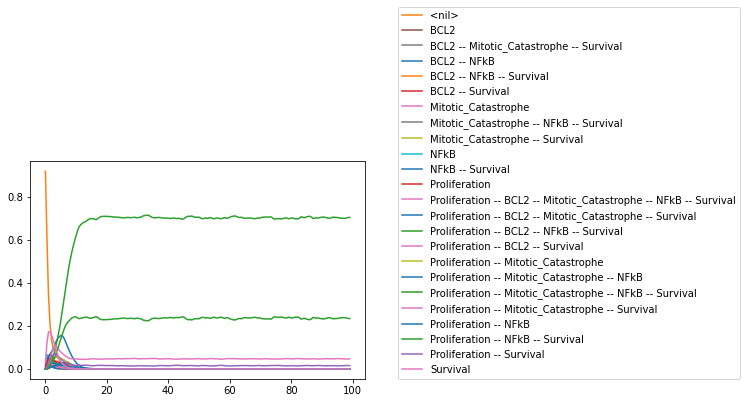

In [48]:
Exp.simu['base']['LS411N'].results.plot_trajectory()

the simulation LS411N|CHEK1_OFF seems not having been computed


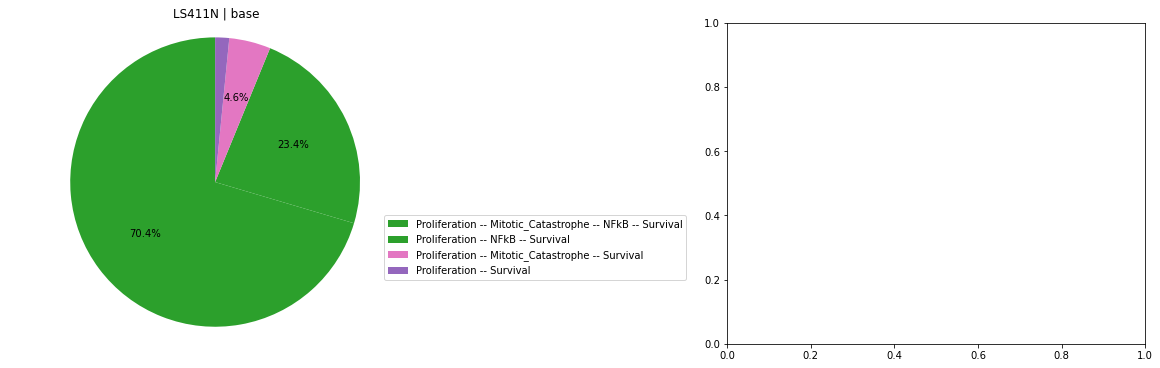

In [49]:
Exp.plot_piechart(celllines = 'LS411N')

Here only the base condition is plotted because the CHEK1 has not been ran

In [50]:
Exp.run_simulation(celllines=['LS411N', 'SW1463', 'SW480', 'SW620', 'SW403'], redo=False)

the simulation LS411N|base will not be re-computed
Simulating SW1463 in the condition base
done
Simulating SW480 in the condition base
done
Simulating SW620 in the condition base
done
Simulating SW403 in the condition base
done
Simulating LS411N in the condition CHEK1_OFF
done
Simulating SW1463 in the condition CHEK1_OFF
done
Simulating SW480 in the condition CHEK1_OFF
done
Simulating SW620 in the condition CHEK1_OFF
done
Simulating SW403 in the condition CHEK1_OFF
done


We simulates the cell line HT29 in all the conditions defined (here : base and CHEK1_OFF)

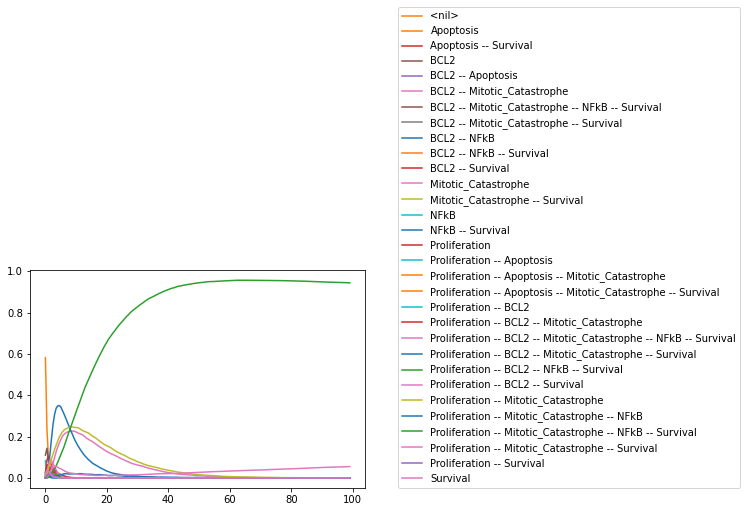

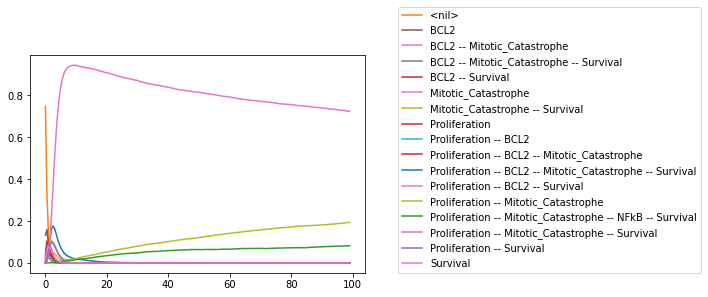

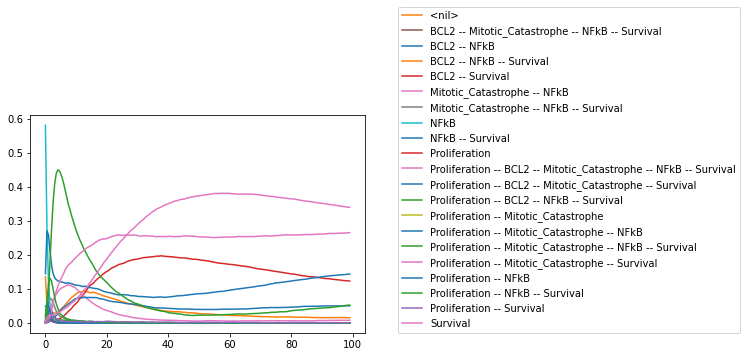

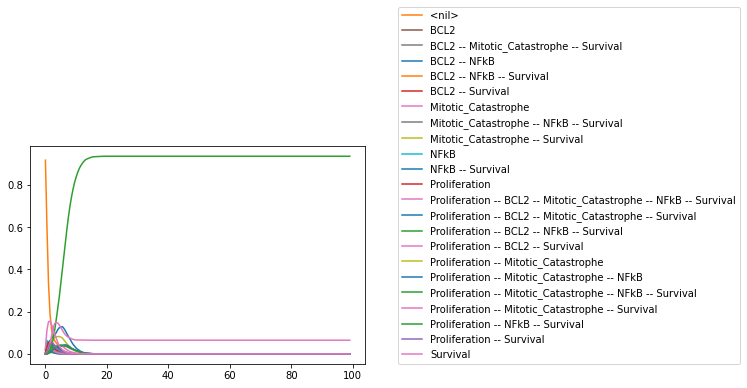

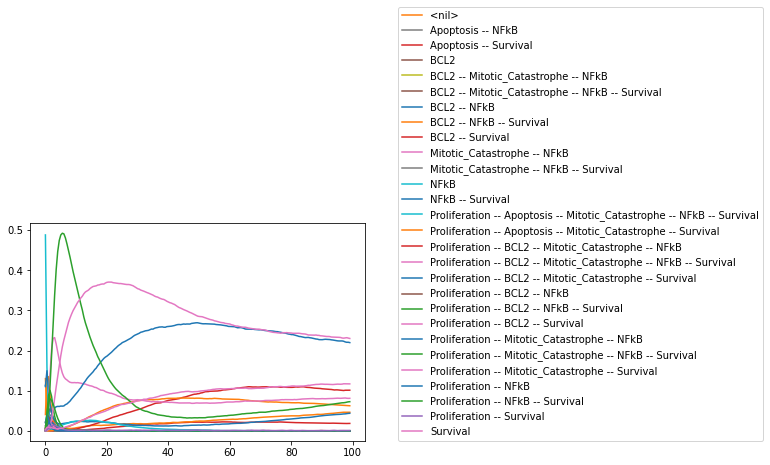

In [51]:
Exp.simu['CHEK1_OFF']['SW620'].results.plot_trajectory()
Exp.simu['CHEK1_OFF']['SW480'].results.plot_trajectory()
Exp.simu['CHEK1_OFF']['SW1463'].results.plot_trajectory()
Exp.simu['CHEK1_OFF']['LS411N'].results.plot_trajectory()
Exp.simu['CHEK1_OFF']['SW403'].results.plot_trajectory()

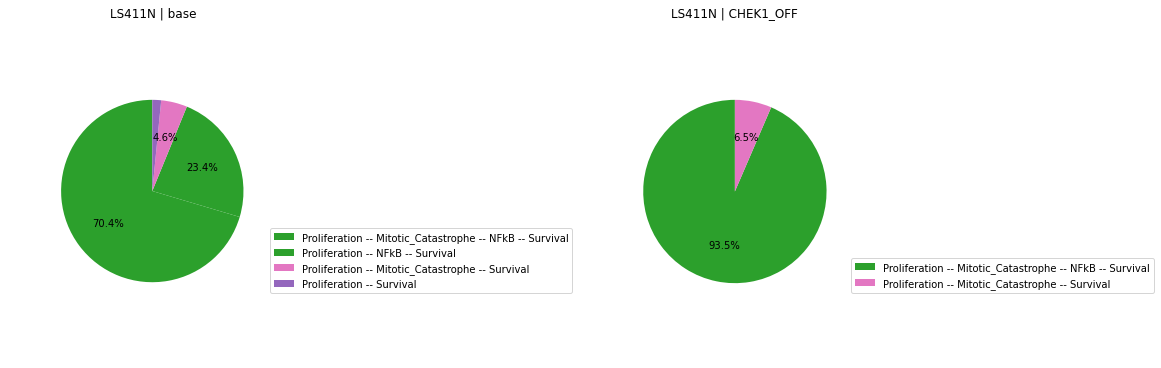

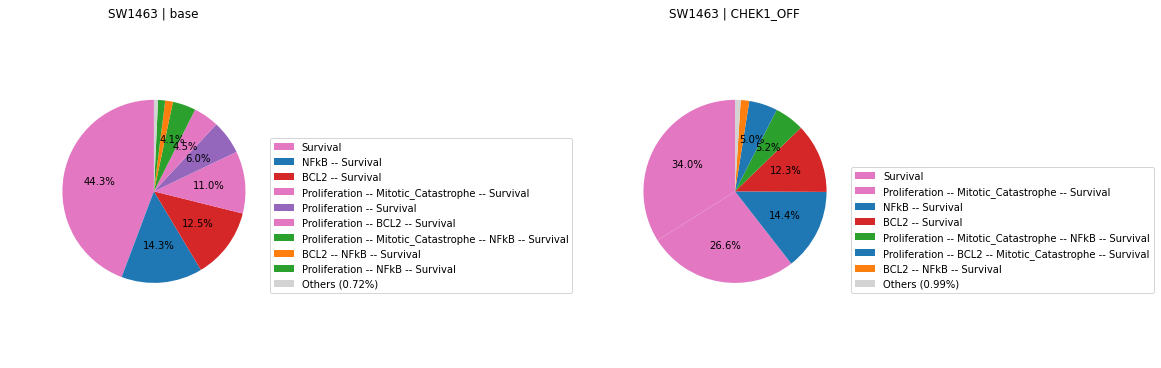

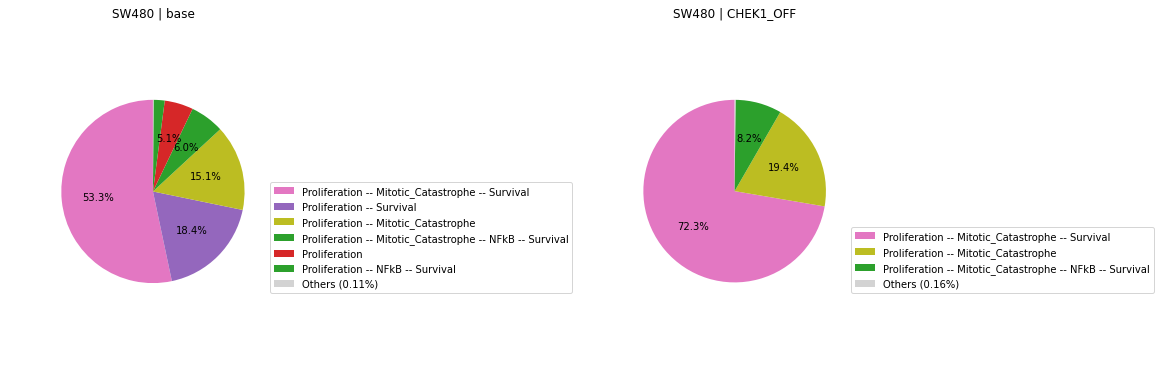

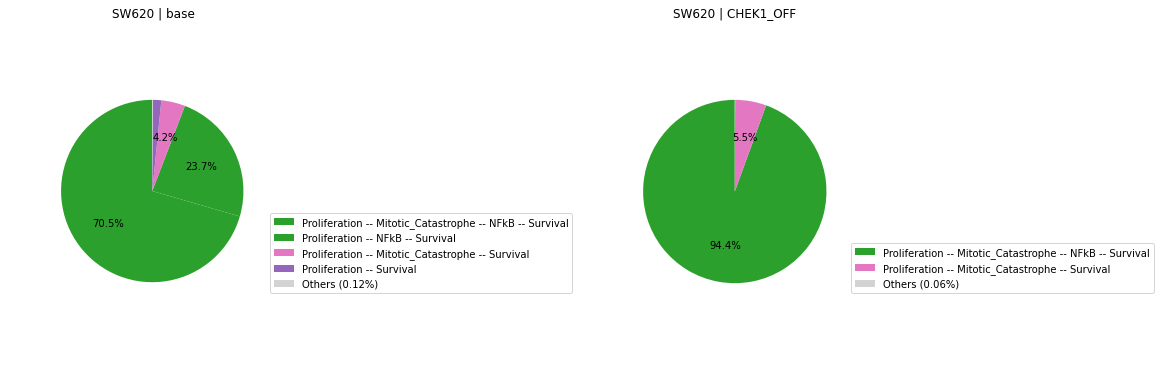

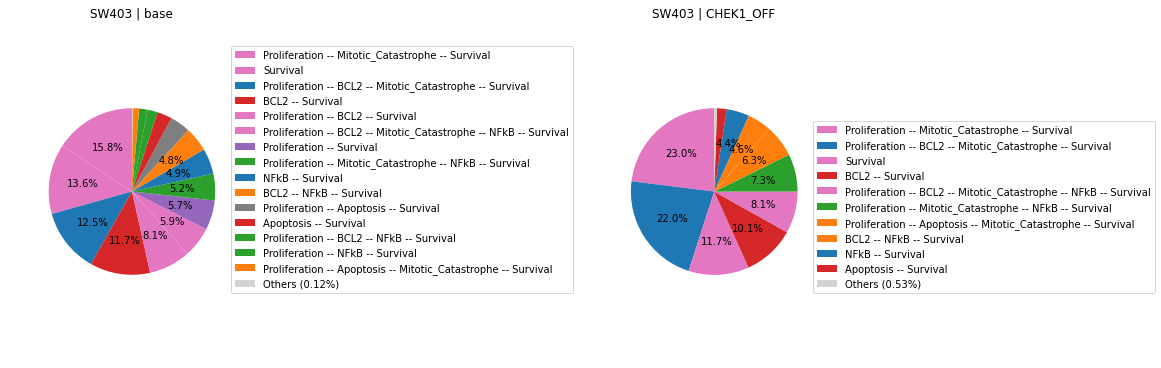

In [52]:
Exp.plot_piechart(celllines = ['LS411N', 'SW1463', 'SW480', 'SW620', 'SW403'])

The method plot_piechart of CellEnsemble just allows to show many piechart in one line (just by precising the cell lines and the conditions that we want tu see). If a simulation (a precise cell line in a precise conditions have not been run, then it returns a message (here : the simulation HT29|CHEK1_ON seems not having been computed). It will still display the results of the other simulations that are available.

Now, we run simulations for all of the cell lines  and all conditions
the argument **redo**=False will allow to skip the simulations that have already been done (here : HT29 in 'base' and 'CHEK1_OFF')

In [53]:
Exp.run_simulation(redo=False)
Exp.resume()

Simulating CAR1 in the condition base
done
Simulating HT29 in the condition base
done
the simulation LS411N|base will not be re-computed
Simulating SW1417 in the condition base
done
the simulation SW1463|base will not be re-computed
the simulation SW403|base will not be re-computed
the simulation SW480|base will not be re-computed
the simulation SW620|base will not be re-computed
Simulating SW837 in the condition base
done
Simulating HCT116 in the condition base
done
Simulating CAR1 in the condition CHEK1_OFF
done
Simulating HT29 in the condition CHEK1_OFF
done
the simulation LS411N|CHEK1_OFF will not be re-computed
Simulating SW1417 in the condition CHEK1_OFF
done
the simulation SW1463|CHEK1_OFF will not be re-computed
the simulation SW403|CHEK1_OFF will not be re-computed
the simulation SW480|CHEK1_OFF will not be re-computed
the simulation SW620|CHEK1_OFF will not be re-computed
Simulating SW837 in the condition CHEK1_OFF
done
Simulating HCT116 in the condition CHEK1_OFF
done


,base,CHEK1_OFF
CAR1,"CAR1, simu","CAR1, simu"
HT29,"HT29, simu","HT29, simu"
LS411N,"LS411N, simu","LS411N, simu"
SW1417,"SW1417, simu","SW1417, simu"
SW1463,"SW1463, simu","SW1463, simu"
SW403,"SW403, simu","SW403, simu"
SW480,"SW480, simu","SW480, simu"
SW620,"SW620, simu","SW620, simu"
SW837,"SW837, simu","SW837, simu"
HCT116,"HCT116, simu","HCT116, simu"


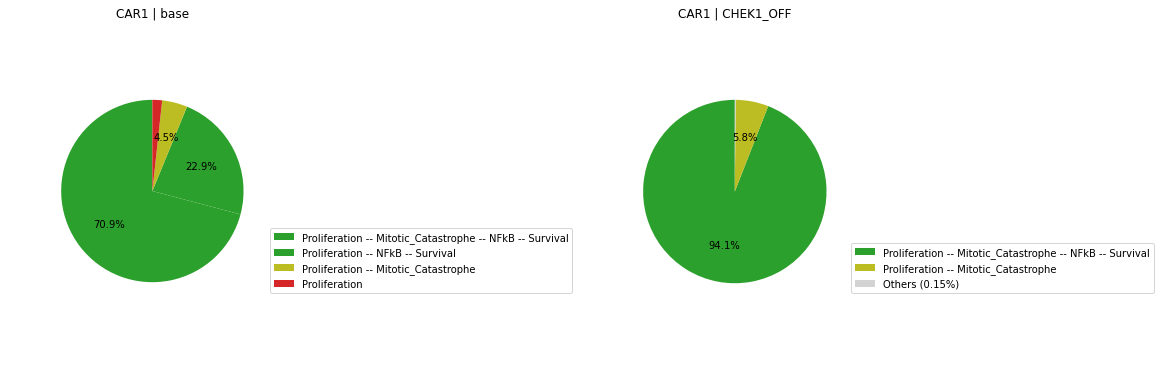

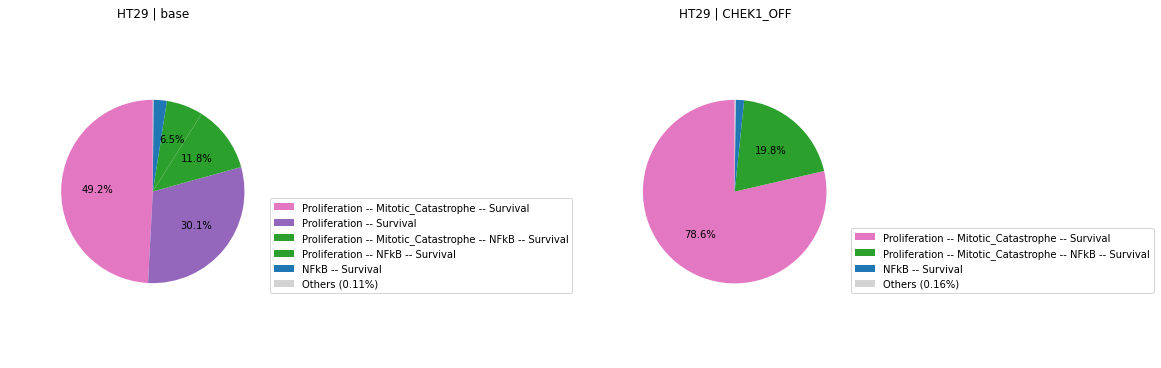

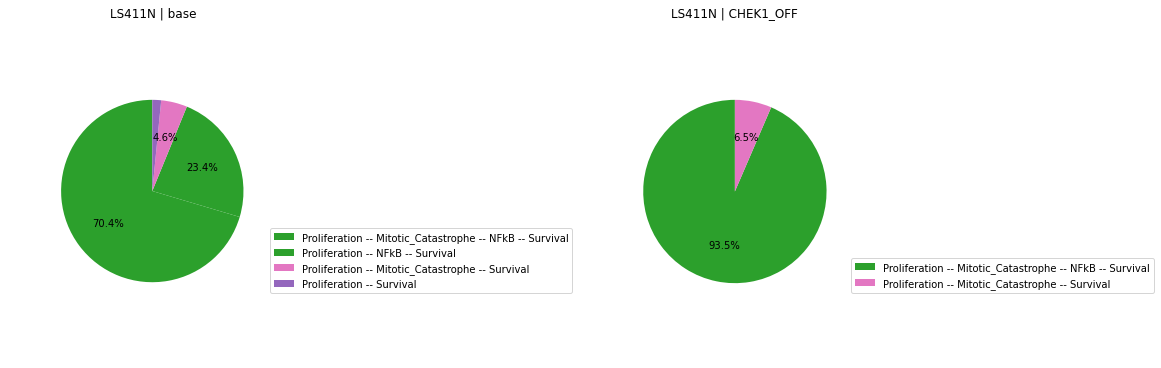

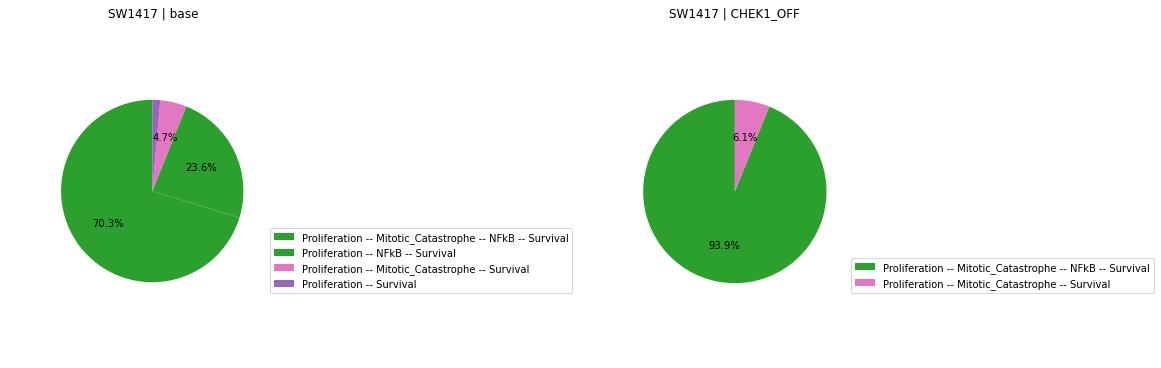

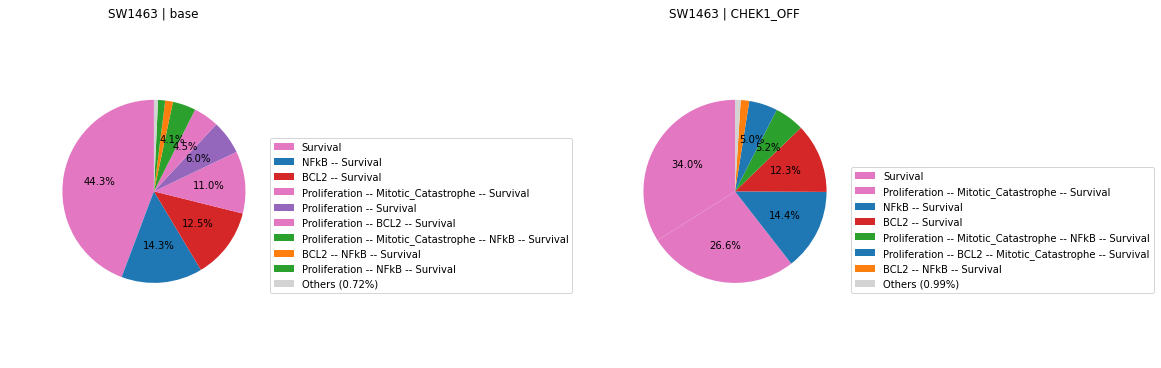

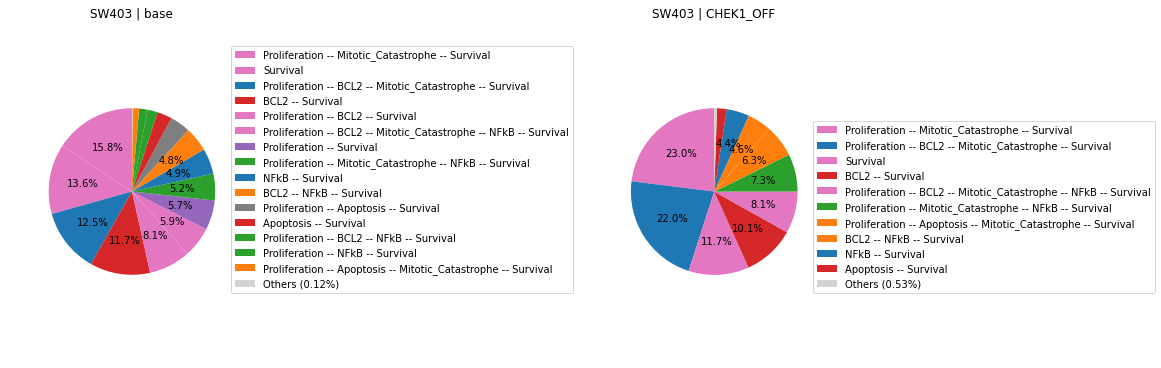

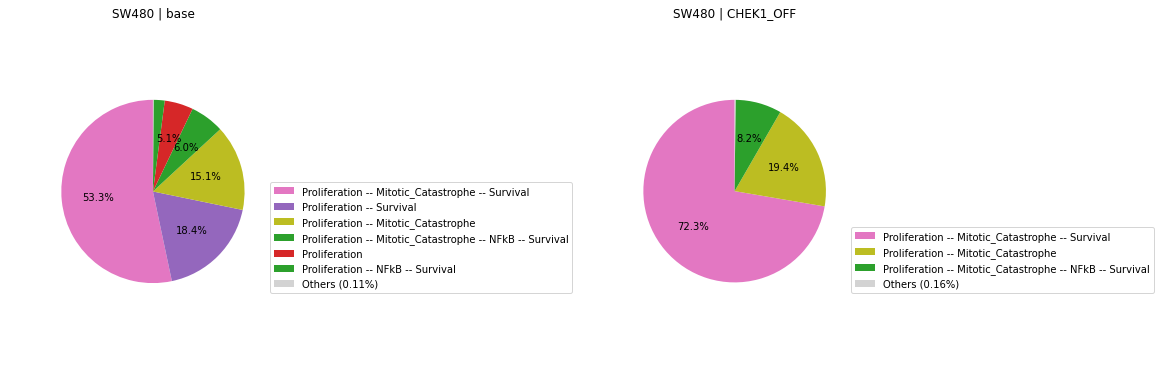

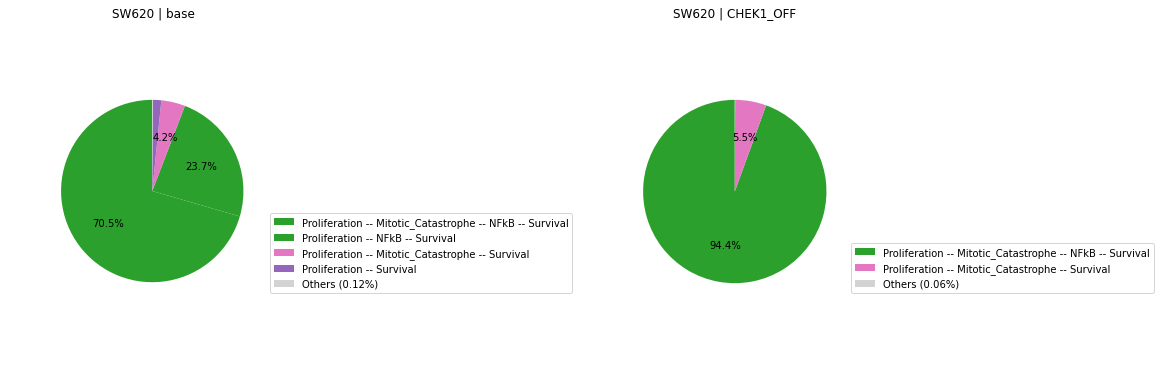

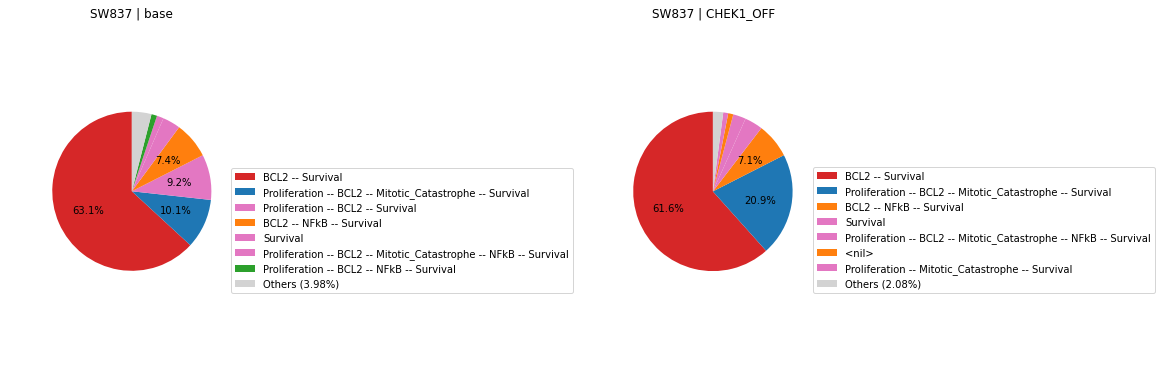

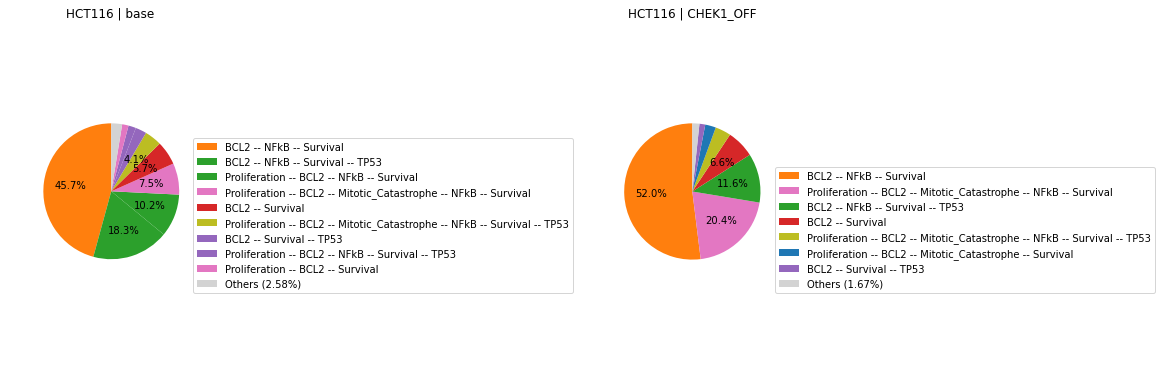

In [54]:
Exp.plot_piechart()

###### Exp.plot_piechart()

In [55]:
#help(sb.scatterplot)

In [ ]:
Exp.add_condition(('MK2', 'OFF'), 'MK2_OFF')
Exp.add_condition([('CHEK1', 'OFF'), ('MK2', 'OFF')], 'CHEK1_OFF|MK2_OFF')

In [ ]:
Exp.run_simulation(conditions='all', redo=False, mute=True)
Exp.resume()

In [ ]:
Exp

In [ ]:
Exp.plot_piechart(conditions='all')

In [ ]:
Exp.plot_piechart(conditions='all')

### **Tentative de comparer la survie** (et la prolifération) **des différentes lignées cellulaires** en regroupant différents états 
#### - survival_rate = les états de survie excluant ceux qui ont aussi MC et apoptose
#### - proliferation_rate = les états de prolifération excluant ceux qui ont aussi MC et apoptose

In [ ]:
Exp.simu['base']['HT29'].results.last_states_probtraj
float(sum(st[s] for s in st if 'Apopotosis' in s or 'Mitotic' in s))

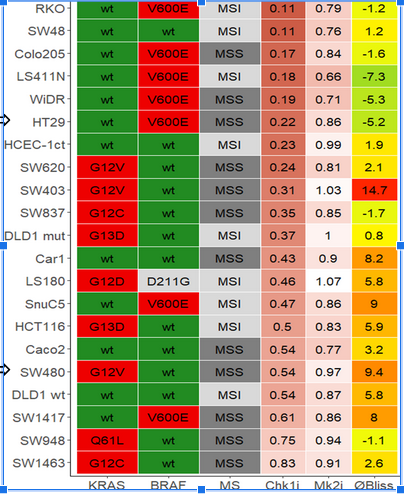

,survival_rates,proliferation_rates
CHEK1_OFF_SW620,0.000000,0.000000
CHEK1_OFF_SW1417,0.000000,0.000000
CHEK1_OFF_LS411N,0.000000,0.000000
CHEK1_OFF_SW480,0.000101,0.000000
CHEK1_OFF_CAR1,0.001500,0.001500
CHEK1_OFF_HT29,0.015372,0.000527
CHEK1_OFF_SW403,0.311194,0.002124
CHEK1_OFF_SW1463,0.622826,0.001012
CHEK1_OFF_HCT116,0.722222,0.002289
CHEK1_OFF_SW837,0.743331,0.001306


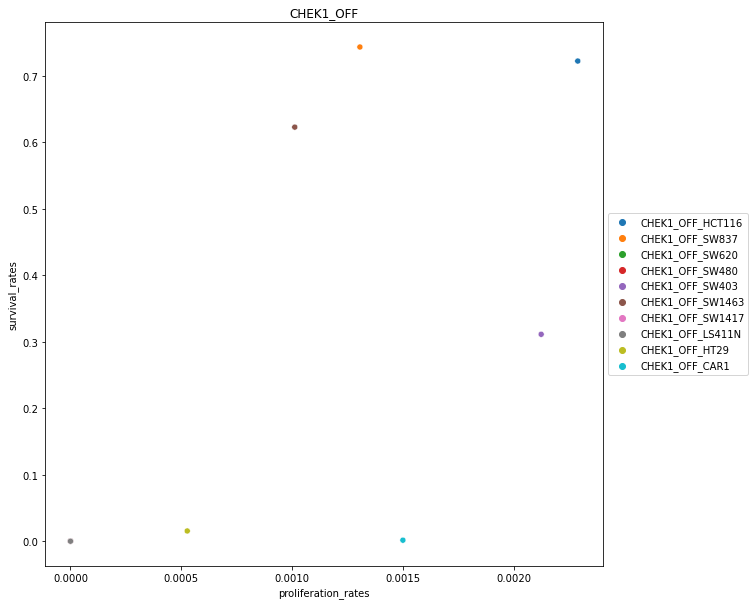

In [56]:
condition1 = 'CHEK1_OFF'

a = Exp.compare_survival(conditions=condition1)
fig, ax = plt.subplots(1,1, figsize = (10,10))   
sb.scatterplot(data = a, x='proliferation_rates', y='survival_rates', hue=a.index, legend='full', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title(condition1)
a.sort_values(by='survival_rates')

In [ ]:
condition1 = 'base'

a = Exp.compare_survival(conditions=condition1)
fig, ax = plt.subplots(1,1, figsize = (10,10))   
sb.scatterplot(data = a, x='proliferation_rates', y='survival_rates', hue=a.index, legend='full', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title(condition1)
a.sort_values(by='survival_rates')

In [ ]:
condition1 = 'CHEK1_OFF|MK2_OFF'

a = Exp.compare_survival(conditions=condition1)
fig, ax = plt.subplots(1,1, figsize = (10,10))   
sb.scatterplot(data = a, x='proliferation_rates', y='survival_rates', hue=a.index, legend='full', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title(condition1)

In [ ]:
###old code use to work on method of CellEnsemble

In [ ]:
conditions = ['base']
clines = list(celllines.keys())

outputs_df = pd.DataFrame(columns = ['proliferation_rates', 'survival_rates'])

for condition in conditions:
    for cellline in clines:
        print('&')
        outputs_dict = {'survival_rates' : {}, 'proliferation_rates' : {}}

        st = Exp.simu[condition][cellline].results.last_states_probtraj
        death_rate = float(sum(st[s] for s in st if 'Apoptosis' in s or 'Mitotic' in s))
        proliferation = float(sum(st[s] for s in st if ('Apoptosis' not in s and 'Mitotic' not in s and 'Prolif' in s)))

        outputs_dict['survival_rates'][condition+'_'+cellline] =  1-death_rate
        outputs_dict['proliferation_rates'][condition+'_'+cellline] = proliferation
        outputs_df = pd.concat([pd.DataFrame(outputs_dict), outputs_df])
        
outputs_df

In [ ]:
outputs_df = pd.DataFrame(index=[], columns=['survival_rate', 'proliferation_rate'])
outputs_df

In [ ]:
to_save = Exp.simu['base']
for cellname in to_save:
    print(cellname)
    to_save[cellline].model.print_cfg()

In [ ]:
outputs_df = pd.DataFrame(index=['survival_rate', 'proliferation_rate'], columns=[])
a = pd.concat([outputs_df, Exp.compare_survival()], axis=1)
a.to_dict()

In [ ]:
A = Exp.simu['base']['HT29'].results.last_states_probtraj
B = Exp.simu['base']['CAR1'].results.last_states_probtraj

In [ ]:
psA = int(sum(A[s] for s in A if 'Apopotosis' in s or 'Mitotic' in s))
ppA = sum(A[s] for s in A if 'Apopotosis' not in s and 'Mitotic' not in s and 'Prolif' in s)
psB = sum(B[s] for s in B if 'Apopotosis' in s or 'Mitotic' in s)
ppB = sum(B[s] for s in B if 'Apopotosis' not in s and 'Mitotic' not in s and 'Prolif' in s)

In [ ]:
type(psA)

In [ ]:
import os
os.getcwd()